# Final Project: Draft Analysis

Dan Wald, Jan Forslow, Jason Harville

## Project Description
No electrical component is 100% efficient. Our national electric grid is composed of thousands of electrical components, and so electrical energy is inevitably lost as it is transmitted from the source of generation to its final end use. It is known that the efficiency of electrical components is affected by both their physical environment (e.g. ambient temperature) and their electromagnetic environment (e.g. the earth's magnetic field), among other things.

This project aims to explore these interactions between electrical power, land weather, and space weather (which affects the earth's magnetic field). This draft analysis combines national datasets for electricity production, consumption, and losses; surface weather and temperatures; and geomagnetic flux. Data is aggregated monthly for the years 2005-2009.

## Data import and formatting

In [1]:
%load_ext autoreload
%autoreload 1
%aimport project_functions
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as plt
import project_functions as pfn

# Used for reading json files from the API
import json
import urllib.request
api_key = '2B92C17D184FEB235C00913E20A82629'

In [2]:
# Imports annual electricity data for the United States (table10)
annual = pfn.table10_merge(state_dict=pfn.states, 
                           file_dir="./Electricity_Data/table10/", 
                           imports_method=3,
                           warnings=False)

# Import monthly electricity data
monthly = pfn.load_monthly_electric(state_dict = pfn.states, 
                                    annual_df=annual, 
                                    import_method=3, 
                                    folder_path='./Electricity_Data/json/', 
                                    warnings=False)

# Import of land surface weather data
weather = pfn.load_weather()

# Combines the different data frames into one
comb = pfn.merge_weather_electric(monthly_df = monthly, weather_df = weather)

In [3]:
# Import satellite data
sat = pd.read_csv('./GOES_Data/MonthlyAggregate_2005-2009.csv')
sat.date = pd.to_datetime(sat.date)
sat.set_index('date', inplace=True)
sat.sort_index(inplace=True)

In [4]:
# Merging sat data with existing electric and weather.
# We now have a single combined dataframe with all datasets.
comb = pd.merge(comb['2005':'2009'], sat, left_index=True, right_index=True)

## Data Description

In [5]:
comb.head()

,gen_tot,gen_com,gen_ind,ret_sales,gen_com_ind,direct_use_est,net_imports_est,losses_est,losses2,PCP,...,he_abs_sum,hn_abs_sum,hp_abs_mean,ht_abs_mean,he_abs_mean,hn_abs_mean,hp_abs_std,ht_abs_std,he_abs_std,hn_abs_std
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,343121.45335,12488.62393,737.18229,309078.80863,13225.80622,13008.817348,29309.603194,50343.430565,21033.827372,2.70,...,1228285.940,440112.235,90.723399,98.271079,27.515366,9.859145,23.086909,20.211961,7.289676,4.720130
2005-02-01,298500.31561,11278.51543,655.82241,279513.81951,11934.33784,11732.921842,43449.872450,50703.446708,7253.574258,2.06,...,1150666.225,392229.510,91.114993,97.932407,28.538349,9.727914,19.097586,16.606045,6.152694,2.854924
2005-03-01,317458.27646,12131.68761,702.42776,286791.11862,12834.11537,12659.211447,7011.165361,25019.111754,18007.946393,2.34,...,1444054.810,416760.860,90.591421,98.995535,32.350347,9.336459,18.571067,14.577927,7.028223,2.807474
2005-04-01,289562.39989,11511.50859,648.83878,264167.93606,12160.34737,11985.413584,-10232.090923,3176.959323,13409.050246,2.57,...,1583715.575,402377.185,94.261907,104.086498,36.660083,9.314287,17.975875,13.493222,9.568374,3.251642
2005-05-01,315062.10994,11852.56015,686.28529,273500.25067,12538.84544,12224.292098,-27132.245147,2205.322025,29337.567172,2.76,...,2059543.600,403128.670,92.390183,107.497710,46.136729,9.030660,18.734194,16.272749,19.288048,4.616192


In [6]:
comb.columns

Index(['gen_tot', 'gen_com', 'gen_ind', 'ret_sales', 'gen_com_ind',
       'direct_use_est', 'net_imports_est', 'losses_est', 'losses2', 'PCP',
       'TAVG', 'PDSI', 'PHDI', 'ZNDX', 'PMDI', 'CDD', 'HDD', 'SP01', 'SP02',
       'SP03', 'SP06', 'SP09', 'SP12', 'SP24', 'TMIN', 'TMAX', 'hp_sum',
       'ht_sum', 'he_sum', 'hn_sum', 'hp_mean', 'ht_mean', 'he_mean',
       'hn_mean', 'hp_std', 'ht_std', 'he_std', 'hn_std', 'hp_min', 'ht_min',
       'he_min', 'hn_min', 'hp_max', 'ht_max', 'he_max', 'hn_max',
       'hp_abs_sum', 'ht_abs_sum', 'he_abs_sum', 'hn_abs_sum', 'hp_abs_mean',
       'ht_abs_mean', 'he_abs_mean', 'hn_abs_mean', 'hp_abs_std', 'ht_abs_std',
       'he_abs_std', 'hn_abs_std'],
      dtype='object')

### Field Descriptions

##### Electricity
- gen_tot: Total net electricity generation.
- gen_com: Total commercial electricity generation.
- gen_ind: Total industrial electricity generation.
- gen_com_ind: Sum of gen_com and gen_ind.
- ret_sales: Total retail sales of electricity.
- direct_use_est: Estimate of electricity used onsite after generation, and never exported to the electric grid.
- net_imports_est: Estimate of net electricity imports.
- losses_est: Estimate of electrical losses, using net_imports_est.
- losses2: Estimate of electrical losses, ignoring net imports.

##### Land Weather
- PCP - Precipitation Index  
- TAVG - Temperature Index  
- TMIN - Minimum Temperature Index  
- TMAX - Maximum Temperature Index  
- PDSI - Palmer Drought Severity Index  
- PHDI - Palmer Hydrological Drought Index  
- ZNDX - Palmer Z-Index  
- PMDI - Modified Palmer Drought Severity Index  
- CDD - Cooling Degree Days
- HDD - Heating Degree Days  
- SPnn - Standard Precipitation Index

Note: CCD is calculated as the number of days * the number of degrees of temperature above baseline. It is used as an indicator of the amount of cooling that is required to maintain baseling. HDD is the opposite. See http://www.degreedays.net/ for definition.

##### Space Weather
- hp: Magnetic field component perpendicular to the earth's orbital plane, positive north.
- ht: Total magnetic field.
- he: Magnetic field component in the Earthward direction, perpendicular to hp.
- hn: Magnetic field in the eastward direction, perpendicular to hp and he.

Magnetic field data is by minute, and so needed to be aggregated to monthly values. Fields with *_function* indicate that the magnetic field data was aggregated using that function. Fields with *_abs_function* indicate that the absolute value of the magnetic field data was aggregated with that function.

## Data Exploration

In [7]:
# Adding two fields:
# Annual temperature average (ATAVG) is the average temperature for that year
# Distance from ATAVG (DTAVG) is the difference between monthly avg and annual avg temperature
annual_tavg = comb.groupby(comb.index.year)['TAVG'].mean()
comb['ATAVG'] = comb.apply(lambda x: annual_tavg[x.name.year], axis=1)
comb['DTAVG'] = (comb['TAVG'] - comb['ATAVG']).abs()

In [8]:
# Creating a dataframe of correlations, sorted by absolute value
# This can be used to identify strong correlations between variables
corr_df = pd.DataFrame(columns = ['var_x', 'var_y', 'corr_val'])
corr_matrix = comb.corr()
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i,j]
        var_x = corr_matrix.iloc[i].name
        var_y = corr_matrix.columns[j]
        corr_df = corr_df.append({'var_x':var_x, 'var_y':var_y, 'corr_val':corr_val}, ignore_index=True)

corr_df['corr_val_abs'] = corr_df['corr_val'].abs()
corr_df.sort_values('corr_val_abs', inplace=True, ascending=False)   

In [9]:
# Displaying top 15 correlations.
corr_df[:15]

,var_x,var_y,corr_val,corr_val_abs
1261,ht_sum,ht_abs_sum,1.000000,1.000000
1383,ht_mean,ht_abs_mean,1.000000,1.000000
1489,ht_std,ht_abs_std,0.999999,0.999999
1228,hp_sum,hp_abs_sum,0.999982,0.999982
1354,hp_mean,hp_abs_mean,0.999960,0.999960
1293,he_sum,he_abs_sum,0.999956,0.999956
1411,he_mean,he_abs_mean,0.999955,0.999955
61,gen_com,gen_com_ind,0.999467,0.999467
1464,hp_std,hp_abs_std,0.999413,0.999413
559,TAVG,TMAX,0.999271,0.999271


#### Transmission vs Temperature

Correlation: 0.303653737882


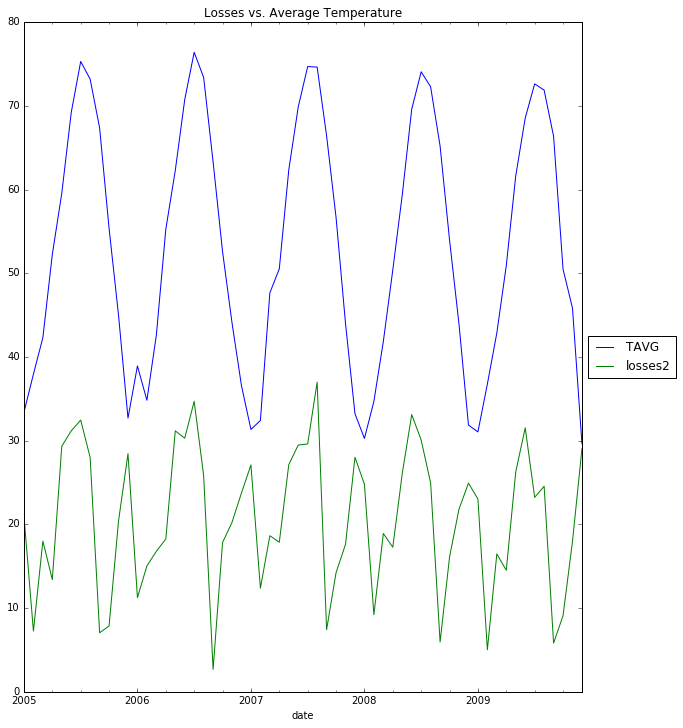

In [10]:
# Plot of Transmissions Losses (losses2/1000) and Monthly Average Temperature (TAVG). 
# Graph indicates higher losses at low and high average temperature.

comb['TAVG'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].apply(lambda x: x/1000).plot(title='Losses vs. Average Temperature', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['TAVG','losses2']
print('Correlation:', corr_val)

Correlation: 0.428668325477


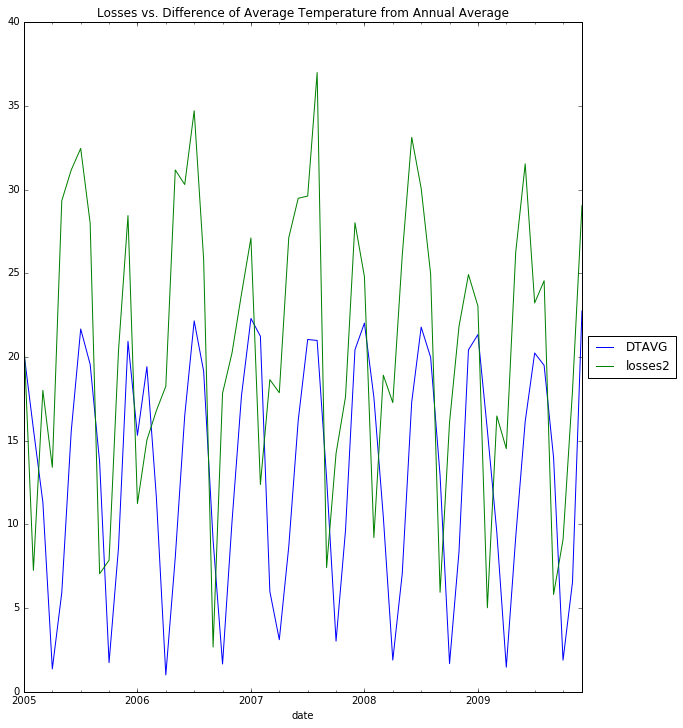

In [11]:
# Test hypothesis that losses are greater at both at low and high temperatures. 
# Does diff from annual average (DTAVG) have a better correlation to losses?

comb['DTAVG'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].apply(lambda x: x/1000).plot(title='Losses vs. Difference of Average Temperature from Annual Average', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['DTAVG','losses2']
print('Correlation:', corr_val)

Correlation: 0.465846290724


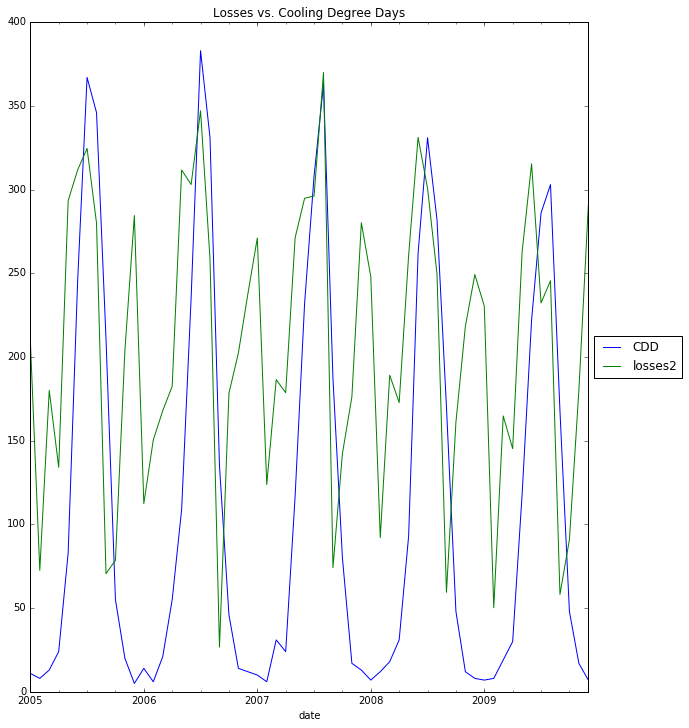

In [12]:
# How about Transmissions Losses (losses2) and Cooling Degree Days (CDD)?

comb['CDD'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].apply(lambda x: x/100).plot(title='Losses vs. Cooling Degree Days', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['CDD','losses2']
print('Correlation:', corr_val)

Correlation: 0.611116056982


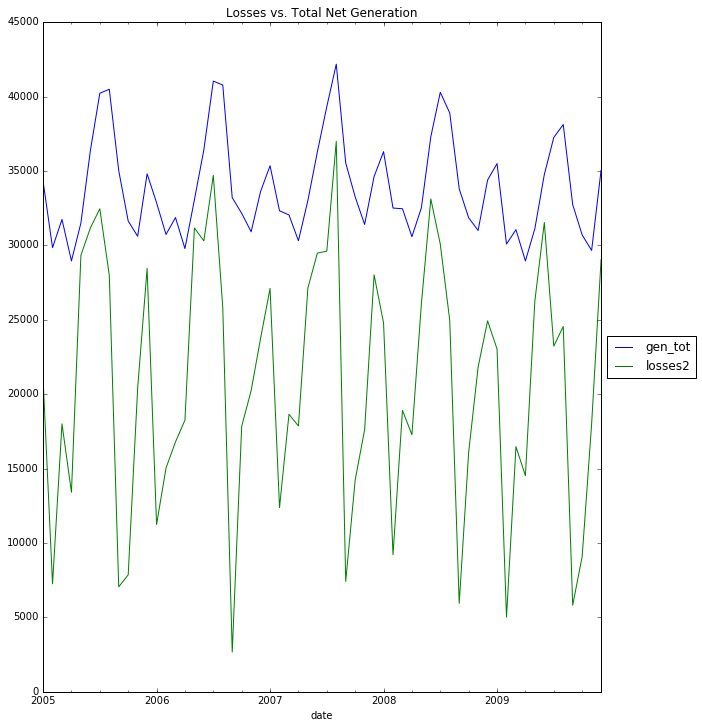

In [13]:
# Transmissions Losses (losses2) should correlate with Total Net Generation (gen_total)

comb['gen_tot'].apply(lambda x: x/10).plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].plot(title='Losses vs. Total Net Generation', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['gen_tot','losses2']
print('Correlation:', corr_val)

#### Transmission vs Magnetic Flux

Correlation: 0.628856394265


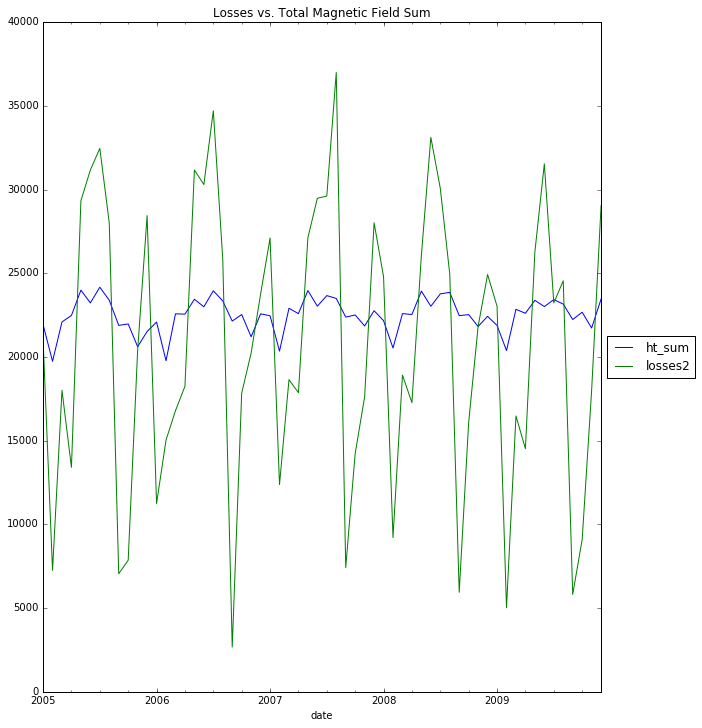

In [14]:
# How does the sum of total magnetic flux relate to transmission losses?

comb['ht_sum'].apply(lambda x: x/200).plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].plot(title='Losses vs. Total Magnetic Field Sum', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['ht_sum','losses2']
print('Correlation:', corr_val)

Correlation: 0.506007040098


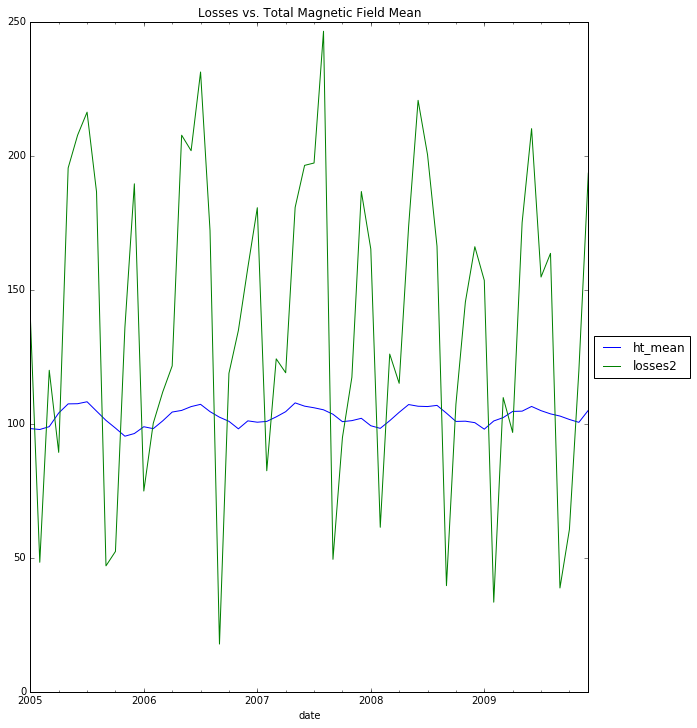

In [15]:
# And the mean of total magnetic field?

comb['ht_mean'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].apply(lambda x: x/150).plot(title='Losses vs. Total Magnetic Field Mean', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['ht_mean','losses2']
print('Correlation:', corr_val)

Correlation: 0.21178332267


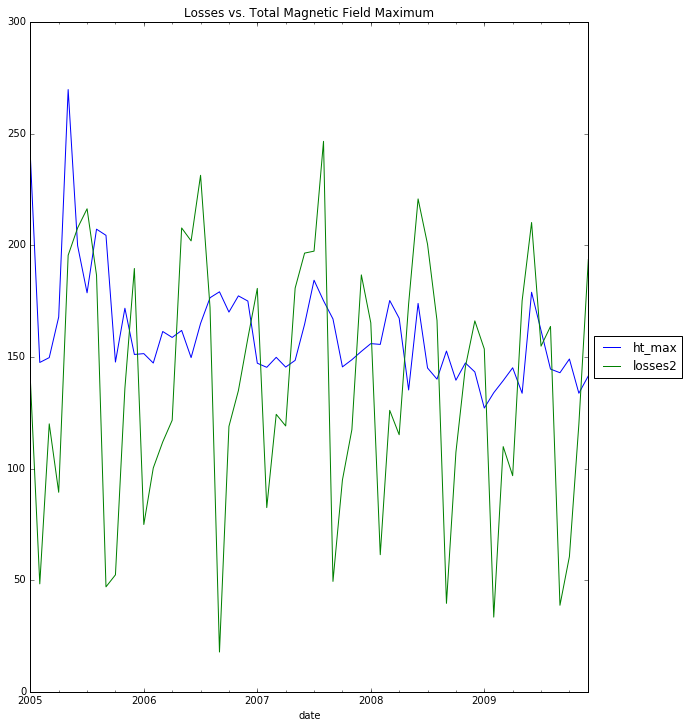

In [16]:
# Monthly magnetic field maximums are a much poorer fit for monthly losses.

comb['ht_max'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['losses2'].apply(lambda x: x/150).plot(title='Losses vs. Total Magnetic Field Maximum', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['ht_max','losses2']
print('Correlation:', corr_val)

#### Other relationships?

Correlation: 0.825747729088


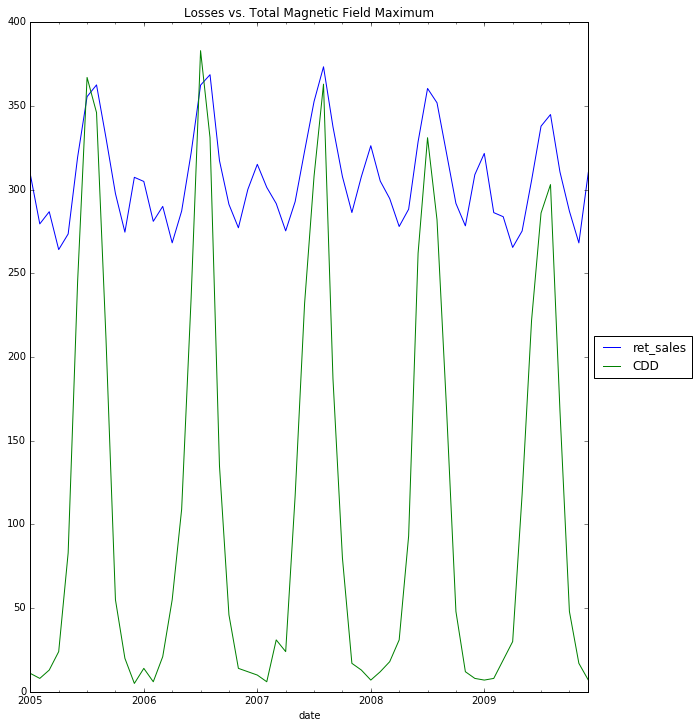

In [17]:
# As expected, retail sales increase with cooling degree days

comb['ret_sales'].apply(lambda x: x/1000).plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['CDD'].plot(title='Losses vs. Total Magnetic Field Maximum', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['ret_sales','CDD']
print('Correlation:', corr_val)

Correlation: 0.765934777577


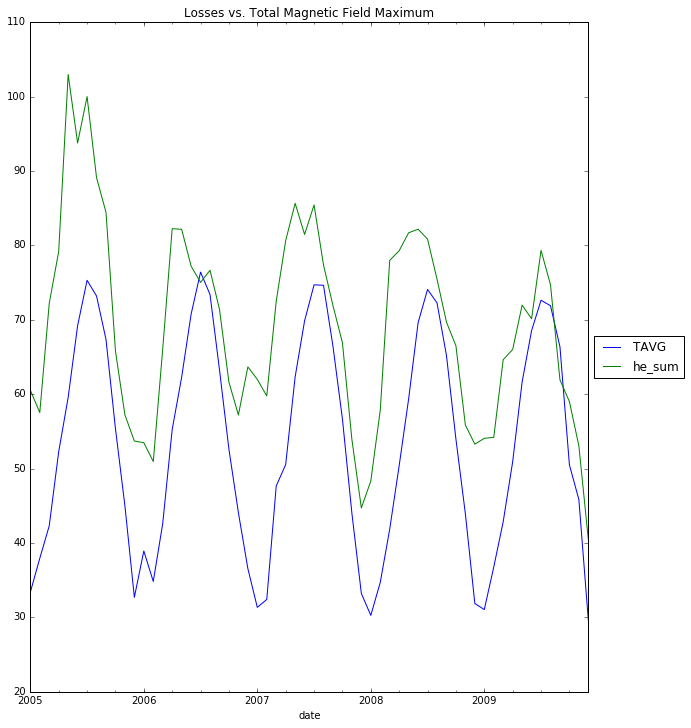

In [18]:
# Temperature is also correlated with magnetic activity, probably due to seasonal cycles.

comb['TAVG'].plot(figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
comb['he_sum'].apply(lambda x: x/20000).plot(title='Losses vs. Total Magnetic Field Maximum', \
                    figsize=(10,12)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

corr_val = corr_matrix.loc['TAVG','he_sum']
print('Correlation:', corr_val)

### Conclusion

This draft analysis confirms many of our hypothesized correlations, and is a demonstration of how these data sets can be used to detect them. For our final report, we intend to refine these hypotheses search the data for any unexpected relationships.